<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1: Build FeedForward Neural Network Architecture 

The goal of this assignment is twofold: (i) implement and use gradient descent (and its variants) with
backpropagation for a classification task (ii) get familiar with wandb which is a cool tool for running and keeping track of a large number of experiments

### Import required packages

In [1]:
from keras.datasets import fashion_mnist
from sklearn import metrics
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
!pip install wandb -qq
import wandb

     |████████████████████████████████| 1.7 MB 8.6 MB/s 
     |████████████████████████████████| 181 kB 54.0 MB/s 
     |████████████████████████████████| 144 kB 10.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


### Log in to wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Assignment_1", name="Question_1")

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

The class labels are one hot encoded so that they can be utilized by the models created below.

In [2]:
#Load the fashion MNIST data 
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

#Normalize the data
x_train_full = x_train_full/255.0
x_test = x_test/255.0

#Splitting to get 10% data as validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=137)

y_train_unencoded = y_train
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()
y_val = encoder.fit_transform(np.expand_dims(y_val,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(y_test,1)).toarray()

4431872/4422102 [==============================] - 0s 0us/step


### Plotting 1 image per class onto console and logging the same to wandb

In [3]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train_unencoded, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

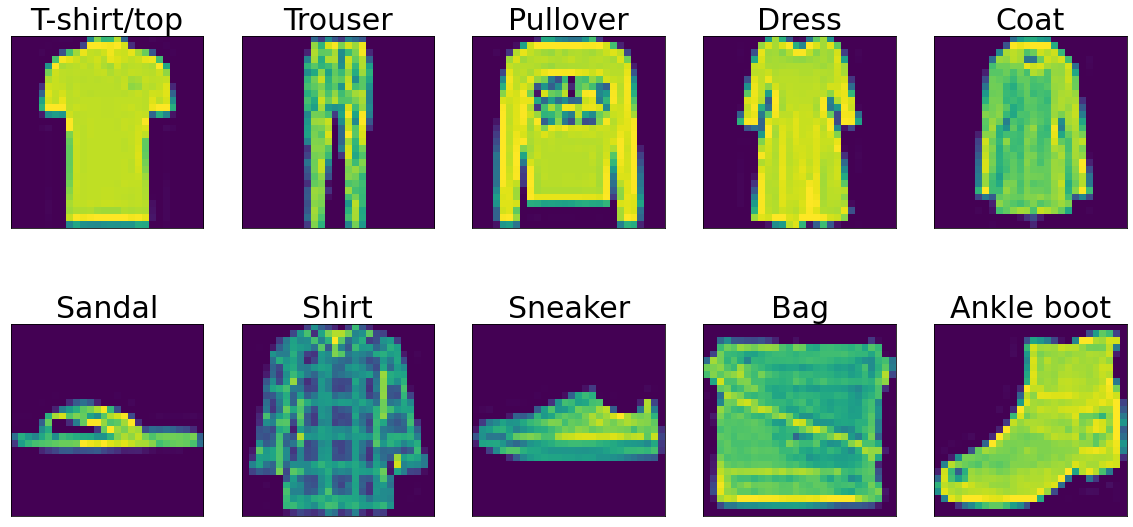

In [ ]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"examples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [ ]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

**Functionalities included:**
1. Forward propogation with sigmoid, relu, tanh activation for hidden layers and softmax activation for output layer
2. Returns the class predictions for each datapoint x after a single forward pass
3. Flexible hidden layer count and sizes as passed during fit function call

**(Assuming that the Question asks only for forward-propogation in the FeedForward Neural Network. In case forward + backward propogation was expected, kindly check the cells for Question 3 which have the complete implemenattion of the FeedForward Neural Network)**





In [4]:
class FeedForwardNeuralNetwork():
  """
  Class to implement the feed forward neural network's forward propogation functonality. Hidden layer sizes are flexible and 4 different activations are supported

  Attributes:
      hidden_layer_sizes: List with the hidden layer sizes (list size indicates the number of hidden layers for the network)
  """
  def __init__(self, hidden_layer_sizes):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.input_layer_size=0
    self.output_layer_size=1
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}

    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    """
    Function to initialize the weights between the layers of the network. Weights are initialized randomly.
    """
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    np.random.RandomState(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))
  
  def compute_activation(self, name, X):
    """
    Function to compute activation based on the name of activation function passed. This function in turn calls the required activation.
    """
    if name=="sigmoid":
      return self.sigmoid(X)
    if name=="relu":
      return self.tanh(X)
    if name=="tanh":
      return self.relu(X)

  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def forward_propogation(self, activation, X):
    """
    Function to perform forward propogation on the data X.
    """
    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)

    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = activation(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.compute_activation(activation, self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return


  def fit(self, activation, X, Y):
    """
    Function to fit the data (X,Y) on the model. This performs a single forward pass and returns the probabilities computed at the output layer
    """
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    y_preds = []
    for x, y in zip(X, Y):
      #Forward Propogation
      self.forward_propogation(activation, x)

      y_preds.append(self.H[len(self.hidden_layer_sizes)+1][0])
    return y_preds
 


### Create an object for the FeedForwardNeuralNetwork class and get class probabilities for the data passed

In [5]:
#Sample implementation using 3 hidden layers of sizes 100, 256 and 512 respectively

model = FeedForwardNeuralNetwork([100,256,512])
activation_name = "relu"
class_predictions = model.fit(activation_name, x_train, y_train)

In [6]:
# Class probabilities for 0th indexed image

np.set_printoptions(suppress=True)
class_predictions[0]

array([0.99455091, 0.        , 0.        , 0.00000199, 0.00001175,
       0.        , 0.00042277, 0.00500862, 0.00000396, 0.00000001])

##Question 3

Implement the backpropagation algorithm with support for the following optimization functions:
* SGD
* Momentum based gradient descent
* Nesterov accelerated gradient descent
* Rmsprop
* Adam
* Nadam

In addition to this, the below section includes the following:
1. Implementation classes for the Sigmoid, Relu, Tanh, Softmax activation functions
2. Implementation classes for Cross entropy loss and Squared error loss functions
3. Provision to choose between Random, Xavier-Normal and Xavier-Uniform weight initialization
4. FeedForwardNeuralNetwork class modified to allow optimizer, hidden layer activation, output layer activation, loss function, hidden layer details, epochs, batch size, weight initialization, ... to be sent as a parameter
5. Accuracy and Loss printed for each epoch for Training and validation data

**Adding a new Optimizer/Activation/Loss function is as simple as creating a class for the same with a a structure following that as other classes and passing it as a parameter to the object of the FeedForwardNeuralNetwork class**

### Creating utility functions

In [4]:
#An independent function which computed accuracy given the true and predicted class labels
def accuracy(y_true, y_pred):
  """
  Utility function to compute the accuracy given true and predicted class labels
  """
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

### Creating the FeedForwardNeuralNetwork class

In [5]:
class FeedForwardNeuralNetwork():
  """
  Class to implement the feed forward neural network's forward propogation functonality.

  Attributes:
      hidden_layer_sizes:List with the hidden layer sizes (list size indicates the number of hidden layers for the network)
      optimizer:Object for the optimizer to be used.
      loss_function:Object for the loss function to be used.
      activation_function:Object for the activation function to be used at the hidden layers.
      output_activation:Object for the activation function to be used at the output layer.
      epochs:Number of epochs (default 1000)
      batch_size:Batch size (default 1024)
      initialization:Weight initialization (default "Random")
      log:Log onto wand (default 0)
      console_log:Log onto console (default 1)
      train_losses_list:List for saving training loss per epoch (default None)
      train_accuracy_list:List for saving training accuracy per epoch (default None)
      val_losses_list:List for saving validation loss per epoch (default None)
      val_accuracy_listList for saving validation accuracy per epoch (default None)
  """
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random", log=0, console_log = 1, train_losses_list = None, train_accuracy_list = None, val_losses_list = None, val_accuracy_list = None):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []
    self.log = log
    self.console_log = console_log
    self.val_losses_list = val_losses_list
    self.val_accuracy_list = val_accuracy_list
    self.train_losses_list = train_losses_list
    self.train_accuracy_list = train_accuracy_list


  def initialize_weights(self):
    """
    Function to initialize the weights between the layers of the network. Weights are initialized randomly.
    """
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    np.random.RandomState(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):
    """
    Function to perform forward propogation on the data X.
    """
    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = activation(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):
    """
    Function to perform backward propogation on the network. 
    """
    #Compute the gradient of loss wrt the activation of output layer
    self.dA[len(self.hidden_layer_sizes)+1] = self.loss_function.last_output_derivative(self.H[len(self.hidden_layer_sizes)+1], Y, self.output_activation.compute_derivative(self.A[len(self.hidden_layer_sizes)+1]))

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      if i!=0:
        #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
        self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
        #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
        ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
        self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.A[i]), self.dH[i])    
    return dw_i, db_i


  def fit(self, X, Y, X_val, Y_val):
    """
    Function to fit the data (X,Y) on the model. This performs forward + backward pass for epoch number of times. Gradient is updated after each batch is processed.
    """    
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          #Done wih current batch
          count = 0
          if self.optimizer.optimizer_name()=="nag":
            w_lookahead = {}
            b_lookahead = {}
            for i in range(len(self.hidden_layer_sizes)+1):
              w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
              b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
            
            weights_old = self.weights
            biases_old = self.biases
            self.weights = w_lookahead
            self.biases = b_lookahead
            self.forward_propogation(x)
            dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
            self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

          else: 
            self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #Predictions
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      if self.optimizer.optimizer_name()=="nag":
        w_lookahead = {}
        b_lookahead = {}
        for i in range(len(self.hidden_layer_sizes)+1):
          w_lookahead[i+1] = self.weights[i+1] - self.optimizer.gamma*self.optimizer.update_history_w[i+1]
          b_lookahead[i+1] = self.biases[i+1] - self.optimizer.gamma*self.optimizer.update_history_b[i+1]
        
        weights_old = self.weights
        biases_old = self.biases
        self.weights = w_lookahead
        self.biases = b_lookahead
        self.forward_propogation(x)
        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, self.hidden_layer_sizes)

      else:  
        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      training_loss = self.loss_function.compute_loss(Y, y_preds, self.batch_size)
      validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation, self.batch_size)
      training_accuracy = accuracy(np.argmax(Y,1), np.argmax(y_preds,1))
      validation_accuracy = accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
      if self.log==1:
        #Log metrics to wandb
        wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})
      if self.console_log == 1:
        #Log results to console
        print("Epoch: ",e+1," Training Loss: ",training_loss, " Validation Loss:",validation_loss ," Training Accuracy: ",training_accuracy, " Validation Accuracy:", validation_accuracy)
      if self.val_accuracy_list != None:
        self.val_accuracy_list.append(validation_accuracy)
      if self.val_losses_list != None:
        self.val_losses_list.append(validation_loss)
      if self.train_accuracy_list != None:
        self.train_accuracy_list.append(training_accuracy)
      if self.train_losses_list != None:
        self.train_losses_list.append(training_loss)
    
    return training_loss, validation_loss, training_accuracy, validation_accuracy

  def predict(self, X):
    """
    Given a list of datapoints X, this function returns the predictions for the data based on the model trained.
    """
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


### Creating classes for Optimizers

In [6]:
class GD():
  """
  Class to implement Stocastic Gradient Descent optimizer.
  Argumenets:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
  """
  def __init__(self, learning_rate = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.weight_decay = parameters["weight_decay"]

  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases


class MomentumGD():
  """
  Class to implement Momentum Gradient Descent optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    gamma : Gamma value for the optimizer
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.001, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.weight_decay = weight_decay
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.weight_decay = parameters["weight_decay"]

  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """

    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class NAG():
  """
  Class to implement Nesterov accelerated Gradient Descent optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    gamma: Gamma value for the optimizer
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.9):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
    self.w_look_ahead={}
    self.b_look_ahead={}
    self.dw_look_ahead={}
    self.db_look_ahead={}

  
  def optimizer_name(self):
    return "nag"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    self.dw_look_ahead.clear()
    self.db_look_ahead.clear()
    self.w_look_ahead.clear()
    self.b_look_ahead.clear()

    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.db_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))
      self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.b_look_ahead[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]

        weights[i+1] = weights[i+1] - self.update_history_w[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  """
  Class to implement RMSProp optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    gamma : Gamma value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):
        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Adam():
  """
  Class to implement Adam optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    beta1 : Beta 1 value for the optimizer
    beta2 : Beta 2 value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001,beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "adam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])
        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(m_w_hat)
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(m_b_hat)

    self.iterations += 1
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  """
  Class to implement NAdam optimizer.
  Arguments:
    learning_rate: Learning rate for the optimizer
    weight_decay: Weight decay for the optimizer
    beta1 : Beta 1 value for the optimizer
    beta2 : Beta 2 value for the optimizer
    epsilon : Epsilon value
  """
  def __init__(self, learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, weight_decay = 0.0):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1
    self.weight_decay = weight_decay

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_weight_decay(self, weight_decay):
    self.weight_decay = weight_decay
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    self.weight_decay = parameters["weight_decay"]


  def update_parameters(self, weights, biases, dw, db, layers):
    """
    Function to perform the weight update step based on optimizer algorithm
    """
    for i in range(len(layers)+1):

        dw[i+1] = dw[i+1] + self.weight_decay*weights[i+1]

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


### Creating classes for Activation functions

In [7]:
class Sigmoid():
  """
  Class to implement Sigmoid activation function.
  """
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    val = self.compute_activation(X)
    return val*(1-val)

class Softmax():
  """
  Class to implement Softmax activation function.
  """
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    softmax = self.compute_activation(X)
    return softmax*(1-softmax)

class Tanh():
  """
  Class to implement Tanh activation function.
  """
  def compute_activation(self,X):
    return np.tanh(X)

  def compute_derivative(self,X):
    return 1 - (np.tanh(X) ** 2)

class ReLU():
  """
  Class to implement Relu activation function.
  """
  def compute_activation(self,X):
    return X * (X > 0)

  def compute_derivative(self,X):
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X

### Creating classes for Loss functions

In [8]:
class CrossEntropy():
  """
  Class to implement cross entropy loss function
  """
  def compute_loss(self, Y_true, Y_pred, batch_size):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)

    return loss

  def name(self):
    return "cross_entropy_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

  def last_output_derivative(self, Y_pred,Y_true,activation_derivative):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return -(Y_true - Y_pred)


class SquaredErrorLoss():
  """
  Class to implement squared loss function
  """
  def compute_loss(self, Y_true, Y_pred, batch_size):
    return (1/2) * np.sum((Y_pred-Y_true)**2)/len(Y_true)

  def name(self):
    return "squared_loss"

  def compute_derivative(self, Y_pred,Y_true):
    return (Y_pred)*(Y_pred-Y_true)/len(Y_true)

  def last_output_derivative(self, Y_pred,Y_true, activation_derivative):
    for p in Y_pred[0]:
      if np.isnan(p) or p<10e-8:
        p=10e-8
    return (Y_pred - Y_true)*activation_derivative/len(Y_true)

### Testing a sample model

In [13]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "ReLU":ReLU()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0}
#optimizer_parameters_momentum = {"learning_rate":0.01, "gamma":0.9}

optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)

#Select optimizer(nag)
optimizer_nag = optimizers["nag"]
optimizer_parameters_nag = {"learning_rate":0.001, "gamma":0.9}
optimizer_nag.set_initial_parameters(optimizer_parameters_nag)

#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.01, "gamma":0.9, "epsilon":1e-8, "weight_decay":0.5}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.5}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]
activation_softmax = activation_functions["softmax"]
activation_tanh = activation_functions["tanh"]
activation_relu = activation_functions["ReLU"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

model = FeedForwardNeuralNetwork(layers, optimizer_sgd, loss_squared, activation_tanh, output_activation_softmax, 5, 512, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.4087083810474027  Validation Loss: 0.366896297644663  Training Accuracy:  0.3954814814814815  Validation Accuracy: 0.5351666666666667
Epoch:  2  Training Loss:  0.33674837292953985  Validation Loss: 0.30761564810217856  Training Accuracy:  0.5490555555555555  Validation Accuracy: 0.5615
Epoch:  3  Training Loss:  0.29165770637016536  Validation Loss: 0.2764169721998846  Training Accuracy:  0.5791851851851851  Validation Accuracy: 0.5991666666666666
Epoch:  4  Training Loss:  0.2672150403412884  Validation Loss: 0.25841862873854227  Training Accuracy:  0.6169629629629629  Validation Accuracy: 0.629
Epoch:  5  Training Loss:  0.2519475207418422  Validation Loss: 0.24626332871963533  Training Accuracy:  0.6444814814814814  Validation Accuracy: 0.6505


(0.2519475207418422, 0.24626332871963533, 0.6444814814814814, 0.6505)

### Sample model prediction on test data

In [14]:
#Accuracy for test data
y_preds = model.predict(x_test)
print(accuracy(np.argmax(y_test,1), np.argmax(y_preds,1)))

0.6503


##Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters.



###Part 1 : Random search over all possible combinations

In [ ]:
sweep_config = {
    #RandomSearch over the hyperparameters
    'method': 'random',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']
        },
        'epochs': {
            'values': [5,10]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.0, 0.0005, 0.5]
        },
        'gamma': {
            'values': [0.3, 0.6, 0.9]
        },

        'activation': {
            'values': ['sigmoid' , 'tanh', 'relu']
        },
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: vwuj9dj0
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/vwuj9dj0


In [ ]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        'weight_decay' : 0.5,
        'batch_size':100
    }
    
    with wandb.init(project='Assignment_1',config = sweep_config, name="Question_345"):
      config = wandb.init().config

      optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
      loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
      activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers_' + str(len(config.hidden_layers)) +'_decay_' + str(config.weight_decay) + '_gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      weight_decay = config.weight_decay
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers
      loss_cross_entropy = loss_functions["cross_entropy"]

      if config.activation=="sigmoid":
        activation = activation_functions["sigmoid"]
      
      if config.activation=="tanh":
        activation = activation_functions["tanh"]

      if config.activation=="relu":
        activation = activation_functions["relu"]

      output_activation = activation_functions["softmax"]

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_sgd)

      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_momentum)

      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer.set_initial_parameters(optimizer_parameters_nag)

      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_rmsprop)

      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_adam)

      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_nadam)


      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1, console_log = 0)
      
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)
      print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)
      del model
      del optimizer
      del activation
      del loss_cross_entropy
      del output_activation
      del hidden_layers

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: u9akuphe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.7969168113929659  Validation Loss: 1.794062953144623  Training Accuracy:  0.2722777777777778  Validation Accuracy: 0.2693333333333333


wandb: Agent Starting Run: nt1mu3u4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5253138058734319  Validation Loss: 0.6288598855529908  Training Accuracy:  0.8243333333333334  Validation Accuracy: 0.7891666666666667


wandb: Agent Starting Run: 2qwezmdm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.306193385175729  Validation Loss: 2.3054205144081736  Training Accuracy:  0.10153703703703704  Validation Accuracy: 0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0rt90ql with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7718644553309029  Validation Loss: 0.7190511339801375  Training Accuracy:  0.7184259259259259  Validation Accuracy: 0.7493333333333333


wandb: Agent Starting Run: tg8bx4sd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30598786205361467  Validation Loss: 0.3396199130275675  Training Accuracy:  0.8885185185185185  Validation Accuracy: 0.8731666666666666


wandb: Agent Starting Run: upv0zv74 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.38038960386980464  Validation Loss: 0.45399463560435166  Training Accuracy:  0.8685  Validation Accuracy: 0.841


wandb: Agent Starting Run: yrow18o2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7925079456586862  Validation Loss: 0.6936596018632202  Training Accuracy:  0.7052777777777778  Validation Accuracy: 0.742


wandb: Agent Starting Run: ndec1u0s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6653728568005585  Validation Loss: 0.6490101735220989  Training Accuracy:  0.750462962962963  Validation Accuracy: 0.7571666666666667


wandb: Agent Starting Run: blo48ybs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5322201952394319  Validation Loss: 0.5413643446443062  Training Accuracy:  0.8311111111111111  Validation Accuracy: 0.8256666666666667


wandb: Agent Starting Run: 4cxefpjw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.266883718786592  Validation Loss: 0.37899056454520896  Training Accuracy:  0.9004444444444445  Validation Accuracy: 0.8685


wandb: Agent Starting Run: v2kevuih with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6341051039420887  Validation Loss: 0.6359511350670178  Training Accuracy:  0.7894629629629629  Validation Accuracy: 0.7795


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uh47eios with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.3752928962998168  Validation Loss: 1.3056293109994088  Training Accuracy:  0.43674074074074076  Validation Accuracy: 0.49083333333333334


wandb: Agent Starting Run: ls73kb60 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.306149492695903  Validation Loss: 2.3054154512373777  Training Accuracy:  0.10325925925925926  Validation Accuracy: 0.1


wandb: Agent Starting Run: z52cmrb6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.3649402930857508  Validation Loss: 1.6228514054530385  Training Accuracy:  0.42303703703703704  Validation Accuracy: 0.39016666666666666


wandb: Agent Starting Run: 35p9zk9w with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5821555611515878  Validation Loss: 0.6254971462746445  Training Accuracy:  0.8104074074074074  Validation Accuracy: 0.7998333333333333


wandb: Agent Starting Run: 8g0u1i6j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.8338068981465554  Validation Loss: 1.7670136169952826  Training Accuracy:  0.2058888888888889  Validation Accuracy: 0.21883333333333332


wandb: Agent Starting Run: 1gis517z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  7.535913656002151  Validation Loss: 6.281646022141018  Training Accuracy:  0.19042592592592592  Validation Accuracy: 0.09583333333333334


wandb: Agent Starting Run: l8u55aya with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.7510537909649386  Validation Loss: 1.6821383006861448  Training Accuracy:  0.5118148148148148  Validation Accuracy: 0.5431666666666667


wandb: Agent Starting Run: reufaddt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.5328843461268022  Validation Loss: 1.450177331305923  Training Accuracy:  0.3783888888888889  Validation Accuracy: 0.44966666666666666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kpytygox with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3798713436107903  Validation Loss: 0.3882327019719709  Training Accuracy:  0.8643518518518518  Validation Accuracy: 0.8588333333333333


wandb: Agent Starting Run: hflatoxj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7101657691832103  Validation Loss: 0.7476683868665953  Training Accuracy:  0.7675925925925926  Validation Accuracy: 0.734


wandb: Agent Starting Run: ebob9tzn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.35876812810299796  Validation Loss: 0.3791331110680364  Training Accuracy:  0.8715740740740741  Validation Accuracy: 0.8626666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1g2qqivo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.27280453948926714  Validation Loss: 0.42178698682466786  Training Accuracy:  0.8992777777777777  Validation Accuracy: 0.864


wandb: Agent Starting Run: gtig1xbz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.1136898899494128  Validation Loss: 1.1033249759349453  Training Accuracy:  0.6721666666666667  Validation Accuracy: 0.6498333333333334


wandb: Agent Starting Run: zy2trora with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.8327324418471398  Validation Loss: 1.8515742832897988  Training Accuracy:  0.23883333333333334  Validation Accuracy: 0.195


wandb: Agent Starting Run: 1md5sy4p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4656184526609969  Validation Loss: 0.4715947549164717  Training Accuracy:  0.8349444444444445  Validation Accuracy: 0.8328333333333333


wandb: Agent Starting Run: krl8s118 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.564783120023252  Validation Loss: 0.5628182842834604  Training Accuracy:  0.8070555555555555  Validation Accuracy: 0.8013333333333333


wandb: Agent Starting Run: xxj6l8nz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5288688867018958  Validation Loss: 0.5214144230653858  Training Accuracy:  0.8159444444444445  Validation Accuracy: 0.8171666666666667


wandb: Agent Starting Run: 1iqpt4tu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.37155545251061434  Validation Loss: 0.41983913463363265  Training Accuracy:  0.8641111111111112  Validation Accuracy: 0.8538333333333333


wandb: Agent Starting Run: 2tulcy5f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


wandb: Agent Starting Run: b7ipc1ov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30629360602892186  Validation Loss: 0.3401797587151375  Training Accuracy:  0.8884814814814814  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: g637ciqr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5181030169051032  Validation Loss: 0.5209062112302987  Training Accuracy:  0.8194444444444444  Validation Accuracy: 0.8151666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bx60rsj8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.9654450127689467  Validation Loss: 1.9566073659614607  Training Accuracy:  0.1947222222222222  Validation Accuracy: 0.19416666666666665


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7bssm106 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.806450882985636  Validation Loss: 0.7982010634697778  Training Accuracy:  0.7429629629629629  Validation Accuracy: 0.7548333333333334


wandb: Agent Starting Run: 1rw2cf42 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5438735199296637  Validation Loss: 0.5513107470603128  Training Accuracy:  0.8030555555555555  Validation Accuracy: 0.7991666666666667


wandb: Agent Starting Run: gzg17y0z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6850366181120637  Validation Loss: 0.6835605461663755  Training Accuracy:  0.786537037037037  Validation Accuracy: 0.779


wandb: Agent Starting Run: z4oi843o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5898425433318991  Validation Loss: 0.5925821398052535  Training Accuracy:  0.8083148148148148  Validation Accuracy: 0.8028333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 947cyug7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3115419816310565  Validation Loss: 0.3486437935850665  Training Accuracy:  0.889  Validation Accuracy: 0.8718333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jg4mixzl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.561464254706075  Validation Loss: 0.5589843356915942  Training Accuracy:  0.8039444444444445  Validation Accuracy: 0.805


wandb: Agent Starting Run: eqwjisyq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.2926692098375234  Validation Loss: 2.245609738727721  Training Accuracy:  0.13564814814814816  Validation Accuracy: 0.19633333333333333


wandb: Agent Starting Run: 9vrzbyn9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.304876549166616  Validation Loss: 2.304830839255644  Training Accuracy:  0.09814814814814815  Validation Accuracy: 0.1


wandb: Agent Starting Run: n0iij7vm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40404352126848214  Validation Loss: 0.41984442438436764  Training Accuracy:  0.855925925925926  Validation Accuracy: 0.8505


wandb: Agent Starting Run: m6641ynu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6008523813789123  Validation Loss: 0.6264857510590378  Training Accuracy:  0.793537037037037  Validation Accuracy: 0.7836666666666666


wandb: Agent Starting Run: 0si3370a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4727959416503522  Validation Loss: 0.4741930124138535  Training Accuracy:  0.8313333333333334  Validation Accuracy: 0.8256666666666667


wandb: Agent Starting Run: nt89t9ru with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.5236149261723873  Validation Loss: 1.5590822941843572  Training Accuracy:  0.3566666666666667  Validation Accuracy: 0.305


wandb: Agent Starting Run: 6xxyasyi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.561464254706075  Validation Loss: 0.5589843356915942  Training Accuracy:  0.8039444444444445  Validation Accuracy: 0.805


wandb: Agent Starting Run: i7qbbowy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3154290307594425  Validation Loss: 0.3864188770396925  Training Accuracy:  0.8847777777777778  Validation Accuracy: 0.8601666666666666


wandb: Agent Starting Run: 3ceg48m0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.7528841816931813  Validation Loss: 1.7785019146847638  Training Accuracy:  0.19670370370370371  Validation Accuracy: 0.19583333333333333


wandb: Agent Starting Run: t0lkwe87 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5058153224871723  Validation Loss: 0.5675334219663554  Training Accuracy:  0.8200185185185185  Validation Accuracy: 0.7958333333333333


wandb: Agent Starting Run: un11zpcl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.44204340884970017  Validation Loss: 0.48626696016539717  Training Accuracy:  0.8584444444444445  Validation Accuracy: 0.8495


wandb: Agent Starting Run: gukz6wni with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4044839598014128  Validation Loss: 0.4141110228442523  Training Accuracy:  0.8557962962962963  Validation Accuracy: 0.8496666666666667


wandb: Agent Starting Run: yuzn9nt8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.2515140626817258  Validation Loss: 1.173591656236924  Training Accuracy:  0.4720185185185185  Validation Accuracy: 0.5648333333333333


wandb: Agent Starting Run: 7dxwwkll with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6372770378624432  Validation Loss: 0.5370786682924916  Training Accuracy:  0.8037037037037037  Validation Accuracy: 0.8201666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojiegyyq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.5773013888615812  Validation Loss: 1.5944565012667782  Training Accuracy:  0.36592592592592593  Validation Accuracy: 0.3485


wandb: Agent Starting Run: hilep9ar with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.518723173652724  Validation Loss: 0.5383056404500032  Training Accuracy:  0.820037037037037  Validation Accuracy: 0.8228333333333333


wandb: Agent Starting Run: p0i29ydf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34561042920678126  Validation Loss: 0.3618529709671165  Training Accuracy:  0.8763888888888889  Validation Accuracy: 0.8673333333333333


wandb: Agent Starting Run: 07raz5hv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.411504641491266  Validation Loss: 1.2352017486038345  Training Accuracy:  0.2943148148148148  Validation Accuracy: 0.375


wandb: Agent Starting Run: yn21wk5s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36809175316773257  Validation Loss: 0.3719619394321891  Training Accuracy:  0.8683888888888889  Validation Accuracy: 0.8653333333333333


wandb: Agent Starting Run: rn2vh9lm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36979138458276456  Validation Loss: 0.37988817387384005  Training Accuracy:  0.8670185185185185  Validation Accuracy: 0.8625


wandb: Agent Starting Run: t4ud66ub with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.9845824868187879  Validation Loss: 0.9848305087453191  Training Accuracy:  0.5689814814814815  Validation Accuracy: 0.5618333333333333


wandb: Agent Starting Run: 53yf44tf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5174478422712567  Validation Loss: 0.5134939630905421  Training Accuracy:  0.822925925925926  Validation Accuracy: 0.8241666666666667


wandb: Agent Starting Run: kcwwz5w3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0214512946655376  Validation Loss: 1.0786028822639677  Training Accuracy:  0.6899074074074074  Validation Accuracy: 0.6408333333333334


wandb: Agent Starting Run: 2d9kn7iy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5714760801855243  Validation Loss: 0.552456047522323  Training Accuracy:  0.8016296296296296  Validation Accuracy: 0.8035


wandb: Agent Starting Run: dhbkygo3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3248679534666725  Validation Loss: 2.3103780586332783  Training Accuracy:  0.10118518518518518  Validation Accuracy: 0.09666666666666666


wandb: Agent Starting Run: 96u8k5f2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.49178572784629293  Validation Loss: 0.49963050772476153  Training Accuracy:  0.832462962962963  Validation Accuracy: 0.8253333333333334


wandb: Agent Starting Run: ix3wyvh2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3195805740165636  Validation Loss: 0.3455767332545006  Training Accuracy:  0.8843518518518518  Validation Accuracy: 0.8736666666666667


wandb: Agent Starting Run: a0m5gr67 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.2056312196476158  Validation Loss: 0.7918271080798299  Training Accuracy:  0.6226481481481482  Validation Accuracy: 0.7138333333333333


wandb: Agent Starting Run: 1myuy7av with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.35969693986940154  Validation Loss: 0.3766778931047062  Training Accuracy:  0.8722222222222222  Validation Accuracy: 0.8656666666666667


wandb: Agent Starting Run: jho6axsi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4154273789290534  Validation Loss: 0.42555899945399356  Training Accuracy:  0.8537777777777777  Validation Accuracy: 0.8508333333333333


wandb: Agent Starting Run: cbwejtvy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.30926484353010203  Validation Loss: 0.37536392722810913  Training Accuracy:  0.8863703703703704  Validation Accuracy: 0.8636666666666667


wandb: Agent Starting Run: dbq4m93h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.7458763451010724  Validation Loss: 2.527367984644557  Training Accuracy:  0.5406851851851852  Validation Accuracy: 0.3458333333333333


wandb: Agent Starting Run: s8net71e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4244223074173427  Validation Loss: 0.42721051199230864  Training Accuracy:  0.8512592592592593  Validation Accuracy: 0.8521666666666666


wandb: Agent Starting Run: c6kwzi6h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6275425617662389  Validation Loss: 0.6383537689126572  Training Accuracy:  0.795  Validation Accuracy: 0.7906666666666666


wandb: Agent Starting Run: wrsntesz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.302963209982066  Validation Loss: 2.3013142502944364  Training Accuracy:  0.1063888888888889  Validation Accuracy: 0.1035


wandb: Agent Starting Run: f5e61hm9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40587736613732334  Validation Loss: 0.5030220636319365  Training Accuracy:  0.8559444444444444  Validation Accuracy: 0.8281666666666667


wandb: Agent Starting Run: 7ud5ejab with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32925682142940355  Validation Loss: 0.36918384138824534  Training Accuracy:  0.8813148148148148  Validation Accuracy: 0.8635


wandb: Agent Starting Run: 6weftyez with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8533094543865539  Validation Loss: 0.7181200722816615  Training Accuracy:  0.666074074074074  Validation Accuracy: 0.7215


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s1t5naps with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3418524704880906  Validation Loss: 0.3648340398363213  Training Accuracy:  0.8769629629629629  Validation Accuracy: 0.8695


wandb: Agent Starting Run: sq5qvhru with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  92.37768195538072  Validation Loss: 49.46544118163412  Training Accuracy:  0.10022222222222223  Validation Accuracy: 0.1


wandb: Agent Starting Run: g7ws5wsr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3372169848820149  Validation Loss: 0.35775653828012133  Training Accuracy:  0.8787592592592592  Validation Accuracy: 0.8673333333333333


wandb: Agent Starting Run: 63vn3r22 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.3
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7159864082071721  Validation Loss: 0.707297372909717  Training Accuracy:  0.7335  Validation Accuracy: 0.7338333333333333


wandb: Agent Starting Run: fcqp7gok with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.48901777271920005  Validation Loss: 0.46793918477957214  Training Accuracy:  0.8233333333333334  Validation Accuracy: 0.831


wandb: Agent Starting Run: 4uga5ftm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.9
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3259812244499956  Validation Loss: 2.3191181041925066  Training Accuracy:  0.09935185185185186  Validation Accuracy: 0.1


wandb: Agent Starting Run: dgbyywov with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


###Part 2 : Random search over shortlisted parameter combinations

* Removed learning_rate 0.01

* Removed gamma 0.9, 0.3

* Removed nag 

* Removed sigmoid

* Removed weight_decay 0.5

* Removed batch size 16

* Added epochs 15 and 20

In [ ]:
sweep_config_2 = {
    #Random Search over the hyperparameters
    'method': 'random',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'momentum', 'rmsprop']
        },
        'epochs': {
            'values': [10,15, 20]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.0, 0.0005]
        },
        'gamma': {
            'values': [0.6]
        },
        'activation': {
            'values': ['tanh', 'relu']
        },
        'hidden_layers': {
            'values': [[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[32,64]
        }
    }
}

In [ ]:
sweep_id_2 = wandb.sweep(sweep_config_2, project="Assignment_1")

Create sweep with ID: ynlg0dtx
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/ynlg0dtx


In [ ]:
def train_2():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'gamma' : 0.6,
        'weight_decay' : 0.5,
        'batch_size':100
    }

    
    with wandb.init(project='Assignment_1',config = sweep_config_2, name="Question_345"):
      config = wandb.init().config

      optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
      loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
      activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

      #Setting custom run name 
      wandb.run.name = 'epochs_' + str(config.epochs) + '_activation_' + config.activation + '_optimizer_' + config.optimizer + '_layers_' + str(len(config.hidden_layers)) +'_decay_' + str(config.weight_decay) + '_gamma_' + str(config.gamma) + '_learning_rate_' + str(config.learning_rate) + '_batch_size_' + str(config.batch_size)
      
      # Config is a variable that holds and saves hyperparameters and inputs
      learning_rate = config.learning_rate
      weight_decay = config.weight_decay
      gamma = config.gamma
      epochs = config.epochs
      hidden_layers = config.hidden_layers
      loss_cross_entropy = loss_functions["cross_entropy"]

      if config.activation=="sigmoid":
        activation = activation_functions["sigmoid"]
      
      if config.activation=="tanh":
        activation = activation_functions["tanh"]

      if config.activation=="relu":
        activation = activation_functions["relu"]
 
      output_activation = activation_functions["softmax"]

      if config.optimizer=="sgd":
        #Select optimizer(sgd)
        optimizer = optimizers["gradient_descent"]
        optimizer_parameters_sgd = {"learning_rate":config.learning_rate, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_sgd)
 
      if config.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = optimizers["momentum_gd"]
        optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":config.gamma, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_momentum)

      if config.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = optimizers["nag"]
        optimizer_parameters_nag = {"learning_rate":config.learning_rate, "gamma":config.gamma}
        optimizer.set_initial_parameters(optimizer_parameters_nag)

      if config.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = optimizers["rmsprop"]
        optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":config.gamma, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_rmsprop)

      if config.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = optimizers["adam"]
        optimizer_parameters_adam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_adam)

      if config.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = optimizers["nadam"]
        optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
        optimizer.set_initial_parameters(optimizer_parameters_nadam)


      batch_size = config.batch_size

      #Model training 
      #Ensure that log=1 parameter is set for logging onto wandb
      model = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal", log=1, console_log = 0)
      
      train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_train, x_val, y_val)
      print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)
      del model
      del optimizer
      del activation
      del loss_cross_entropy
      del output_activation
      del hidden_layers

      #Log validation accuracy for this run
      wandb.log({"accuracy": val_accuracy})



In [ ]:
wandb.agent(sweep_id_2, train_2)

wandb: Agent Starting Run: 08c29gzc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23231823408027905  Validation Loss: 0.3639102258556352  Training Accuracy:  0.9111296296296296  Validation Accuracy: 0.8723333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ul4dg7ui with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3517537979842532  Validation Loss: 0.36943085008013093  Training Accuracy:  0.8749259259259259  Validation Accuracy: 0.8681666666666666


wandb: Agent Starting Run: km4347go with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3438728779309449  Validation Loss: 0.369914911725091  Training Accuracy:  0.8786296296296296  Validation Accuracy: 0.8675


wandb: Agent Starting Run: rb0srnpg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3097204765230277  Validation Loss: 0.3448578203003414  Training Accuracy:  0.887537037037037  Validation Accuracy: 0.8738333333333334


wandb: Agent Starting Run: 9dom448k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.20830534212287483  Validation Loss: 0.3585680909568484  Training Accuracy:  0.9232777777777778  Validation Accuracy: 0.8803333333333333


wandb: Agent Starting Run: f7h43q6l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.21426731405757982  Validation Loss: 0.399188027833889  Training Accuracy:  0.9193888888888889  Validation Accuracy: 0.8735


wandb: Agent Starting Run: ixbltgux with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2638265699539896  Validation Loss: 0.3561752248660511  Training Accuracy:  0.9020185185185186  Validation Accuracy: 0.8758333333333334


wandb: Agent Starting Run: 64rqp9h0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3574768359928596  Validation Loss: 0.37406831778016264  Training Accuracy:  0.8716666666666667  Validation Accuracy: 0.8616666666666667


wandb: Agent Starting Run: cadue1zt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.27205644043481564  Validation Loss: 0.33306502230466034  Training Accuracy:  0.9008888888888889  Validation Accuracy: 0.8771666666666667


wandb: Agent Starting Run: cq57hqov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2471263734143551  Validation Loss: 0.3486646548526178  Training Accuracy:  0.9089814814814815  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: roqujzr4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2543077326695485  Validation Loss: 0.33519067268423397  Training Accuracy:  0.9055  Validation Accuracy: 0.8815


wandb: Agent Starting Run: crtevtb3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2622180323962413  Validation Loss: 0.38342996493385634  Training Accuracy:  0.9006851851851851  Validation Accuracy: 0.8693333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tuaicaoa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2998139575812714  Validation Loss: 0.3515638128108231  Training Accuracy:  0.8911111111111111  Validation Accuracy: 0.8715


wandb: Agent Starting Run: yxuzskkj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26698286859098225  Validation Loss: 0.35575158786849403  Training Accuracy:  0.9  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: 0mt2kcgv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2617514975786299  Validation Loss: 0.3522055101868991  Training Accuracy:  0.8992777777777777  Validation Accuracy: 0.8761666666666666


wandb: Agent Starting Run: t49fjyen with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.309867094586117  Validation Loss: 0.3428000739308573  Training Accuracy:  0.8875925925925926  Validation Accuracy: 0.8753333333333333


wandb: Agent Starting Run: bfzohcgy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2272947177166554  Validation Loss: 0.3765475327393815  Training Accuracy:  0.9126481481481481  Validation Accuracy: 0.8763333333333333


wandb: Agent Starting Run: kcd648xy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.19619402747765138  Validation Loss: 0.4071297656938277  Training Accuracy:  0.9247777777777778  Validation Accuracy: 0.8791666666666667


wandb: Agent Starting Run: lurmu5em with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.33872206071929445  Validation Loss: 0.3698749889277713  Training Accuracy:  0.8779814814814815  Validation Accuracy: 0.8675


wandb: Agent Starting Run: hrw903ze with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2727731589283527  Validation Loss: 0.32291108170677923  Training Accuracy:  0.9007777777777778  Validation Accuracy: 0.8823333333333333


wandb: Agent Starting Run: k1m2r1j1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4430426576217721  Validation Loss: 0.4539181495226891  Training Accuracy:  0.8455185185185186  Validation Accuracy: 0.8423333333333334


wandb: Agent Starting Run: c9obgpmy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36818574297107526  Validation Loss: 0.39501411661128594  Training Accuracy:  0.8702962962962963  Validation Accuracy: 0.8631666666666666


wandb: Agent Starting Run: 6thboe3q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26927293629692745  Validation Loss: 0.3654295955707527  Training Accuracy:  0.8999814814814815  Validation Accuracy: 0.8695


wandb: Agent Starting Run: anil8kz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2610319062115622  Validation Loss: 0.35702947486834213  Training Accuracy:  0.9039444444444444  Validation Accuracy: 0.8743333333333333


wandb: Agent Starting Run: o3xs6xac with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3257351813408968  Validation Loss: 0.3630716990482048  Training Accuracy:  0.8852962962962962  Validation Accuracy: 0.8715


wandb: Agent Starting Run: sn3lzcpj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.28121770027554027  Validation Loss: 0.3444966947885275  Training Accuracy:  0.8968703703703703  Validation Accuracy: 0.876


wandb: Agent Starting Run: mu23dks9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3474137127625933  Validation Loss: 0.36947353627216967  Training Accuracy:  0.8749259259259259  Validation Accuracy: 0.8625


wandb: Agent Starting Run: 7plb4ck6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23930355270220294  Validation Loss: 0.33861043912604155  Training Accuracy:  0.9100555555555555  Validation Accuracy: 0.885


wandb: Agent Starting Run: ims8uq0y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.437677397006945  Validation Loss: 0.45189925730907454  Training Accuracy:  0.8462407407407407  Validation Accuracy: 0.8423333333333334


wandb: Agent Starting Run: wqo2t319 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.41932724985282144  Validation Loss: 0.4339851850313875  Training Accuracy:  0.8517592592592592  Validation Accuracy: 0.8413333333333334


wandb: Agent Starting Run: wf3c5z12 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23516191268549205  Validation Loss: 0.37076146134834925  Training Accuracy:  0.9122222222222223  Validation Accuracy: 0.875


wandb: Agent Starting Run: mkf7s6j7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2552604695111866  Validation Loss: 0.3386167227163479  Training Accuracy:  0.9056481481481482  Validation Accuracy: 0.882


wandb: Agent Starting Run: 6hai6uyg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.27647811313930765  Validation Loss: 0.32646012353616743  Training Accuracy:  0.8993888888888889  Validation Accuracy: 0.8776666666666667


wandb: Agent Starting Run: mfgcm9iw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.20116360033497957  Validation Loss: 0.3851909192323146  Training Accuracy:  0.9254444444444444  Validation Accuracy: 0.875


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tdffhlo6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2272947177166554  Validation Loss: 0.3765475327393815  Training Accuracy:  0.9126481481481481  Validation Accuracy: 0.8763333333333333


wandb: Agent Starting Run: uz1ebylf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.20570917561108507  Validation Loss: 0.3722015291438232  Training Accuracy:  0.9236296296296296  Validation Accuracy: 0.8785


wandb: Agent Starting Run: 3d200jep with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32972726142763586  Validation Loss: 0.3592335134340423  Training Accuracy:  0.8842037037037037  Validation Accuracy: 0.8705


wandb: Agent Starting Run: 926rfqxg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3768287570623733  Validation Loss: 0.4000976495850144  Training Accuracy:  0.8668148148148148  Validation Accuracy: 0.8568333333333333


wandb: Agent Starting Run: uvf71ry7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23930355270220294  Validation Loss: 0.33861043912604155  Training Accuracy:  0.9100555555555555  Validation Accuracy: 0.885


wandb: Agent Starting Run: 213np57n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.35063756281160063  Validation Loss: 0.36784860024796073  Training Accuracy:  0.8747962962962963  Validation Accuracy: 0.8695


wandb: Agent Starting Run: v3f2p60n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23221330107755667  Validation Loss: 0.3623338980407397  Training Accuracy:  0.9133333333333333  Validation Accuracy: 0.8785


wandb: Agent Starting Run: wtkk811i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.19923287308347745  Validation Loss: 0.3950300069544431  Training Accuracy:  0.924537037037037  Validation Accuracy: 0.8736666666666667


wandb: Agent Starting Run: ql6p0kkl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2996251467847533  Validation Loss: 0.34155923380772885  Training Accuracy:  0.8922037037037037  Validation Accuracy: 0.8723333333333333


wandb: Agent Starting Run: enqfpyr6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4102549836463352  Validation Loss: 0.5097925953083907  Training Accuracy:  0.867037037037037  Validation Accuracy: 0.8621666666666666


wandb: Agent Starting Run: l90yalau with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36212054424323636  Validation Loss: 0.403420872012027  Training Accuracy:  0.8792777777777778  Validation Accuracy: 0.869


wandb: Agent Starting Run: 71i8efol with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.29675701960168066  Validation Loss: 0.3678327783037179  Training Accuracy:  0.8933703703703704  Validation Accuracy: 0.8726666666666667


wandb: Agent Starting Run: 66fjuhcc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3142884428344348  Validation Loss: 0.35619228107903117  Training Accuracy:  0.8846111111111111  Validation Accuracy: 0.8748333333333334


wandb: Agent Starting Run: ydvmo65l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.22636137763356004  Validation Loss: 0.37268744468840137  Training Accuracy:  0.9171851851851852  Validation Accuracy: 0.8728333333333333


wandb: Agent Starting Run: dnyffke8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.20501644642270783  Validation Loss: 0.4164737165987608  Training Accuracy:  0.9208703703703703  Validation Accuracy: 0.8723333333333333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfk9cfou with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3574768359928596  Validation Loss: 0.37406831778016264  Training Accuracy:  0.8716666666666667  Validation Accuracy: 0.8616666666666667


wandb: Agent Starting Run: mvbgcn0t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.40365452691645104  Validation Loss: 0.41972616456036893  Training Accuracy:  0.8559814814814815  Validation Accuracy: 0.85


wandb: Agent Starting Run: yi2ua8mo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3498913689343343  Validation Loss: 0.37833917453194515  Training Accuracy:  0.8745555555555555  Validation Accuracy: 0.8613333333333333


wandb: Agent Starting Run: xdcxmkrm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.22935449125582455  Validation Loss: 0.3924838223741389  Training Accuracy:  0.9116851851851852  Validation Accuracy: 0.8713333333333333


wandb: Agent Starting Run: dtq76135 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.29981220452276286  Validation Loss: 0.34168374955104686  Training Accuracy:  0.8920925925925925  Validation Accuracy: 0.8726666666666667


wandb: Agent Starting Run: 8kwruecy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


 Training Loss:  0.4078529874190663  Validation Loss: nan  Training Accuracy:  0.8726481481481482  Validation Accuracy: 0.8646666666666667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a1sga7fa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2613698822981209  Validation Loss: 0.35152253209225215  Training Accuracy:  0.9025555555555556  Validation Accuracy: 0.8708333333333333


wandb: Agent Starting Run: x2mo9shw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.33872206071929445  Validation Loss: 0.3698749889277713  Training Accuracy:  0.8779814814814815  Validation Accuracy: 0.8675


wandb: Agent Starting Run: 5286cab7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2079986492704534  Validation Loss: 0.3794423743826513  Training Accuracy:  0.9208333333333333  Validation Accuracy: 0.8706666666666667


wandb: Agent Starting Run: uzxmyjp8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.31944835407620553  Validation Loss: 0.35855385286250446  Training Accuracy:  0.8842777777777778  Validation Accuracy: 0.87


wandb: Agent Starting Run: n9zwcc7w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.31588232824508344  Validation Loss: 0.4213895817856044  Training Accuracy:  0.8912222222222222  Validation Accuracy: 0.8606666666666667


wandb: Agent Starting Run: pulo57r4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3718510690058139  Validation Loss: 0.39419407160015846  Training Accuracy:  0.8668703703703704  Validation Accuracy: 0.8566666666666667


wandb: Agent Starting Run: 6e1hx253 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32362571905307264  Validation Loss: 0.35788785108327753  Training Accuracy:  0.8847592592592592  Validation Accuracy: 0.8721666666666666


wandb: Agent Starting Run: wh9obbw5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3622701802629942  Validation Loss: 0.38164602151510696  Training Accuracy:  0.8721296296296296  Validation Accuracy: 0.8631666666666666


wandb: Agent Starting Run: hjyppnwj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36185959055632455  Validation Loss: 0.3868303779900977  Training Accuracy:  0.871537037037037  Validation Accuracy: 0.8588333333333333


wandb: Agent Starting Run: qqsk7894 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.33872206071929445  Validation Loss: 0.3698749889277713  Training Accuracy:  0.8779814814814815  Validation Accuracy: 0.8675


wandb: Agent Starting Run: zm8anuvu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


wandb: Agent Starting Run: 4l3vufd9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.23930355270220294  Validation Loss: 0.33861043912604155  Training Accuracy:  0.9100555555555555  Validation Accuracy: 0.885


wandb: Agent Starting Run: hlz7k631 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3257351813408968  Validation Loss: 0.3630716990482048  Training Accuracy:  0.8852962962962962  Validation Accuracy: 0.8715


wandb: Agent Starting Run: p8jry4lg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.35973551997881364  Validation Loss: 0.385290442323977  Training Accuracy:  0.8746851851851852  Validation Accuracy: 0.8663333333333333


wandb: Agent Starting Run: n29l8evs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3706560008769159  Validation Loss: 0.4876750979299874  Training Accuracy:  0.8751851851851852  Validation Accuracy: 0.8656666666666667


wandb: Agent Starting Run: rn10kc8a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.20830534212287483  Validation Loss: 0.3585680909568484  Training Accuracy:  0.9232777777777778  Validation Accuracy: 0.8803333333333333


wandb: Agent Starting Run: nyvl2fqz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26796830416792444  Validation Loss: 0.36142612602657537  Training Accuracy:  0.9007407407407407  Validation Accuracy: 0.8731666666666666


wandb: Agent Starting Run: 5z6roteb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.26519959329683174  Validation Loss: 0.38142966762735114  Training Accuracy:  0.9004629629629629  Validation Accuracy: 0.8696666666666667


wandb: Agent Starting Run: y0xz1a88 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2291387196380455  Validation Loss: 0.358940915859754  Training Accuracy:  0.9159814814814815  Validation Accuracy: 0.8788333333333334


wandb: Agent Starting Run: i53g9ok6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Ctrl + C detected. Stopping sweep.


##Question 7: Best model

Fine tuning the best model from above sweep gave the model : 
* Epoch:15
* Activation:Relu
* Optimizer: Adam
* Layers : [32,64,128]
* Weight_decay:0.0005
* Gamma:0.6
* Learning_rate:0.001
* Batch_size:64

In [15]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

#Select optimizer(adam)
optimizer_adam = Adam()
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select loss function
loss_cross_entropy = CrossEntropy()

#Select activation(hidden layers)
activation_relu = ReLU()

#Select activation(output layer)
output_activation_softmax = Softmax()

model = FeedForwardNeuralNetwork(layers, optimizer_adam, loss_cross_entropy, activation_relu, output_activation_softmax, 15, 64, initialization = "Xavier-Normal")
model.fit(x_train, y_train, x_val, y_val)


Epoch:  1  Training Loss:  0.5780620834995882  Validation Loss: 0.427809018434692  Training Accuracy:  0.7929074074074074  Validation Accuracy: 0.8478333333333333
Epoch:  2  Training Loss:  0.4061067554700474  Validation Loss: 0.39125845162647527  Training Accuracy:  0.853037037037037  Validation Accuracy: 0.8555
Epoch:  3  Training Loss:  0.36490562587178943  Validation Loss: 0.3708809792307583  Training Accuracy:  0.8660925925925926  Validation Accuracy: 0.8638333333333333
Epoch:  4  Training Loss:  0.33988050269011344  Validation Loss: 0.3669098186881914  Training Accuracy:  0.8747222222222222  Validation Accuracy: 0.8641666666666666
Epoch:  5  Training Loss:  0.3226324609529306  Validation Loss: 0.37487222735978276  Training Accuracy:  0.8804074074074074  Validation Accuracy: 0.8613333333333333
Epoch:  6  Training Loss:  0.30884642176457916  Validation Loss: 0.34835300521122514  Training Accuracy:  0.8847962962962963  Validation Accuracy: 0.871
Epoch:  7  Training Loss:  0.29687889

(0.23783734767055323,
 0.329770429637296,
 0.9111851851851852,
 0.8893333333333333)

In [16]:
#Accuracy for test data
y_pred = model.predict(x_test)
print("Accuracy for Test data", accuracy(np.argmax(y_test,1), np.argmax(y_pred,1)))

Accuracy for Test data 0.8803


**Result** : The best model gave a test accuracy of 88.03%

###Plotting Confusion matrix for test data predictions and logging onto wandb

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


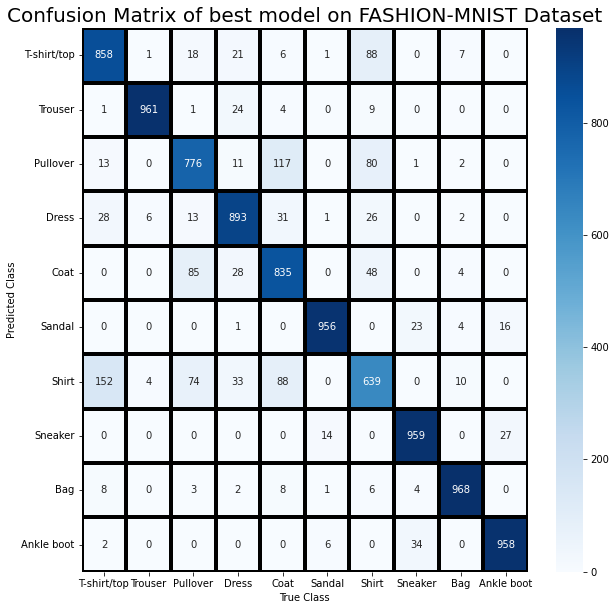

In [17]:
wandb.init(project="Assignment_1", name="Question_7")

#labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

conf_matrix=metrics.confusion_matrix(np.argmax(y_test,1), np.argmax(y_pred,1))
df_conf_matrix = pd.DataFrame(conf_matrix, index=[i for i in labels], columns=[i for i in labels])

plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_conf_matrix, annot=True,  cmap='Blues', fmt='d',linewidths=3, linecolor='black')
ax.set_yticklabels(labels,rotation=0)
plt.xlabel("True Class")  
plt.ylabel("Predicted Class")
plt.title('Confusion Matrix of best model on FASHION-MNIST Dataset', fontsize=20)

wandb.log({"Confusion_matrix": wandb.Image(plt)})

plt.show()

wandb.finish()

##Question 8: Squared loss v/s Cross entropy loss

Comparison of the best model using Cross Entropy v/s Squared Loss

In [19]:
#Add layer sizes for the hidden layers
layers = [32, 64, 128]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

#Select optimizer(adam)
optimizer_adam_1 = Adam()
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam_1.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(adam)
optimizer_adam_2 = Adam()
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam_2.set_initial_parameters(optimizer_parameters_adam)

#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_relu = activation_functions["relu"]

#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]

train_losses_crossentropy = []
train_accuracy_crossentropy = []
val_losses_crossentropy = []
val_accuracy_crossentropy = []

train_losses_squareloss = []
train_accuracy_squareloss = []
val_losses_squareloss = []
val_accuracy_squareloss = []

model_crossEnt = FeedForwardNeuralNetwork(layers, optimizer_adam_1, loss_cross_entropy, activation_relu, output_activation_softmax, 15, 64, initialization = "Xavier-Normal", train_losses_list = train_losses_crossentropy, train_accuracy_list = train_accuracy_crossentropy, val_losses_list = val_losses_crossentropy, val_accuracy_list = val_accuracy_crossentropy)
model_squared = FeedForwardNeuralNetwork(layers, optimizer_adam_2, loss_squared, activation_relu, output_activation_softmax, 15, 64, initialization = "Xavier-Normal", train_losses_list = train_losses_squareloss, train_accuracy_list = train_accuracy_squareloss, val_losses_list = val_losses_squareloss, val_accuracy_list = val_accuracy_squareloss)

model_crossEnt.fit(x_train, y_train, x_val, y_val)
print("-----------------------------------------------------------------------------------")
model_squared.fit(x_train, y_train, x_val, y_val)



Epoch:  1  Training Loss:  0.5780620834995882  Validation Loss: 0.427809018434692  Training Accuracy:  0.7929074074074074  Validation Accuracy: 0.8478333333333333
Epoch:  2  Training Loss:  0.4061067554700474  Validation Loss: 0.39125845162647527  Training Accuracy:  0.853037037037037  Validation Accuracy: 0.8555
Epoch:  3  Training Loss:  0.36490562587178943  Validation Loss: 0.3708809792307583  Training Accuracy:  0.8660925925925926  Validation Accuracy: 0.8638333333333333
Epoch:  4  Training Loss:  0.33988050269011344  Validation Loss: 0.3669098186881914  Training Accuracy:  0.8747222222222222  Validation Accuracy: 0.8641666666666666
Epoch:  5  Training Loss:  0.3226324609529306  Validation Loss: 0.37487222735978276  Training Accuracy:  0.8804074074074074  Validation Accuracy: 0.8613333333333333
Epoch:  6  Training Loss:  0.30884642176457916  Validation Loss: 0.34835300521122514  Training Accuracy:  0.8847962962962963  Validation Accuracy: 0.871
Epoch:  7  Training Loss:  0.29687889

(0.07631832748015795,
 0.08952200237150079,
 0.8966296296296297,
 0.8756666666666667)

###Logging the results of comparison using plots onto wandb

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


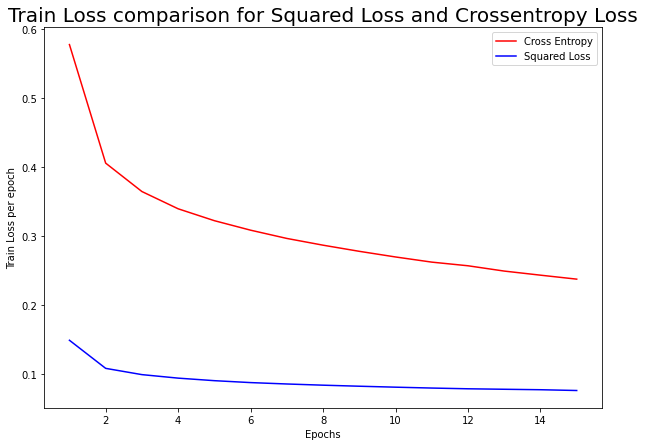

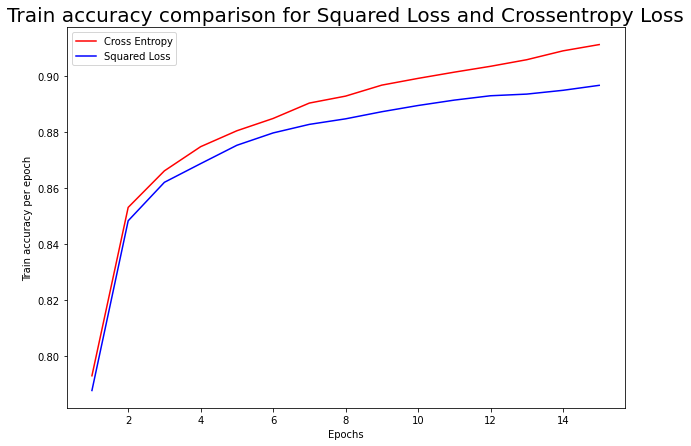

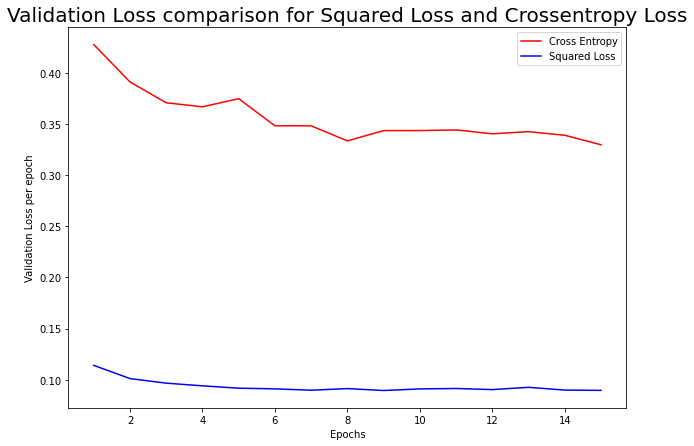

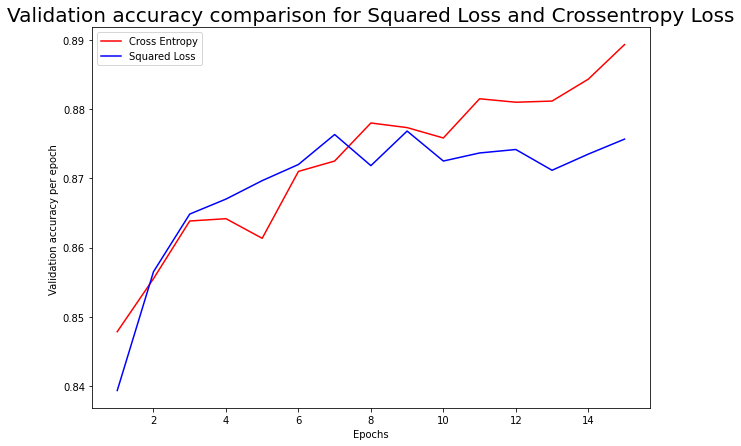

In [20]:
wandb.init(project="Assignment_1", name="Question_8")

epochs = list(range(1, len(train_losses_squareloss)+1))

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train Loss per epoch")
plt.title('Train Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, train_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Train accuracy per epoch")
plt.title('Train accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Train accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_losses_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_losses_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation Loss per epoch")
plt.title('Validation Loss comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation Loss per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



plt.figure(figsize=(10, 7))
plt.plot(epochs, val_accuracy_crossentropy, 'r', label ='Cross Entropy')
plt.plot(epochs, val_accuracy_squareloss, 'b', label ='Squared Loss') 
plt.legend()
plt.xlabel("Epochs")  
plt.ylabel("Validation accuracy per epoch ")
plt.title('Validation accuracy comparison for Squared Loss and Crossentropy Loss', fontsize=20)
wandb.log({"Validation accuracy per epoch for Squared v/s CrossEntropy Loss ": wandb.Image(plt)})
plt.show()



wandb.finish()

##Question 10: MNIST (Number) dataset classification using the top 3 hyperparameter sets from the models of Fashion MNIST

###Download MNIST numbers dataset, normalize and split into train and validation set

In [21]:
(x_train_mnist_full, y_train_mnist_full), (x_test_mnist, y_test_mnist) = mnist.load_data()

#Normalize the data
x_train_mnist_full = x_train_mnist_full/255.0
x_test_mnist = x_test_mnist/255.0

#Splitting to get 10% data as validation set
x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(x_train_mnist_full, y_train_mnist_full, test_size=0.1, random_state=137)

y_train_mnist_unencoded = y_train_mnist
#One hot encoding of the class labels
encoder = OneHotEncoder()
y_train_mnist = encoder.fit_transform(np.expand_dims(y_train_mnist,1)).toarray()
y_val_mnist = encoder.fit_transform(np.expand_dims(y_val_mnist,1)).toarray()
y_test_mnist = encoder.fit_transform(np.expand_dims(y_test_mnist,1)).toarray()


11501568/11490434 [==============================] - 0s 0us/step


### Create the 3 models as follows:

1. MODEL 1: Epoch:15, activation:relu, optimizer:adam, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:64
2. MODEL 2: Epoch:15, activation:tanh, optimizer:sgd, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:32
3. MODEL 3: Epoch:16, activation:tanh, optimizer:nadam, layers : [32,64,128], weight_decay:0.0005, gamma:0.6, learning_rate:0.001, batch_size:64

In [35]:
#Add layer sizes for the hidden layers
layers_3 = [32, 64, 128]
layers_4 = [32, 64, 128, 256]

optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "nag":NAG(), "rmsprop":RMSProp(), "adam":Adam(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy(), "squared_loss":SquaredErrorLoss()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax(), "tanh": Tanh(), "relu":ReLU()}

#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.001, "weight_decay":0.0005}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(adam)
optimizer_adam = optimizers["adam"]
optimizer_parameters_adam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_adam.set_initial_parameters(optimizer_parameters_adam)

#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.0005}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]
loss_squared = loss_functions["squared_loss"]

#Select activation(hidden layers)
activation_tanh = activation_functions["tanh"]
activation_relu = activation_functions["relu"]


#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]


### Fitting the 3 best model hyperparameters with the train data and checking validation accuracy

In [36]:
model_mnist_1 = FeedForwardNeuralNetwork(layers_3, optimizer_adam, CrossEntropy(), ReLU(), Softmax(), 15, 64, initialization = "Xavier-Normal")
model_mnist_1.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.3574642174029229  Validation Loss: 0.18269282274530232  Training Accuracy:  0.8918333333333334  Validation Accuracy: 0.9451666666666667
Epoch:  2  Training Loss:  0.1674638341532952  Validation Loss: 0.140112887616971  Training Accuracy:  0.9495925925925925  Validation Accuracy: 0.958
Epoch:  3  Training Loss:  0.12726835781929857  Validation Loss: 0.12874727833020239  Training Accuracy:  0.9616111111111111  Validation Accuracy: 0.963
Epoch:  4  Training Loss:  0.10380329022796199  Validation Loss: 0.12431876887264133  Training Accuracy:  0.9685185185185186  Validation Accuracy: 0.9638333333333333
Epoch:  5  Training Loss:  0.08799501474819355  Validation Loss: 0.11920871723639588  Training Accuracy:  0.9729814814814814  Validation Accuracy: 0.964
Epoch:  6  Training Loss:  0.07536906065036159  Validation Loss: 0.11799959138874594  Training Accuracy:  0.9770555555555556  Validation Accuracy: 0.9655
Epoch:  7  Training Loss:  0.06558263345067551  Validation 

(0.02913006509827142, 0.15441112871113147, 0.9904074074074074, 0.968)

In [32]:
model_mnist_2 = FeedForwardNeuralNetwork(layers_3, optimizer_sgd, CrossEntropy(), Tanh(), Softmax(), 15, 32, initialization = "Xavier-Normal")
model_mnist_2.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.4387528209573523  Validation Loss: 0.25314256866725393  Training Accuracy:  0.8766481481481482  Validation Accuracy: 0.9248333333333333
Epoch:  2  Training Loss:  0.22939295028167245  Validation Loss: 0.1870995379280432  Training Accuracy:  0.9333148148148148  Validation Accuracy: 0.9458333333333333
Epoch:  3  Training Loss:  0.17763888911794604  Validation Loss: 0.15700497996882581  Training Accuracy:  0.9473703703703704  Validation Accuracy: 0.956
Epoch:  4  Training Loss:  0.1486752063910431  Validation Loss: 0.14165039402432092  Training Accuracy:  0.9561481481481482  Validation Accuracy: 0.9601666666666666
Epoch:  5  Training Loss:  0.12932928859572354  Validation Loss: 0.13291887863731286  Training Accuracy:  0.9613148148148148  Validation Accuracy: 0.9621666666666666
Epoch:  6  Training Loss:  0.11481280545349394  Validation Loss: 0.12729325967666916  Training Accuracy:  0.9653888888888889  Validation Accuracy: 0.9626666666666667
Epoch:  7  Training 

(0.05499609065878757, 0.11814984995353439, 0.9844074074074074, 0.967)

In [33]:
model_mnist_3 = FeedForwardNeuralNetwork(layers_3, optimizer_nadam, CrossEntropy(), Tanh(), Softmax(), 16, 64, initialization = "Xavier-Normal")
model_mnist_3.fit(x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist)

Epoch:  1  Training Loss:  0.3497378177297012  Validation Loss: 0.19839374584721695  Training Accuracy:  0.8977592592592593  Validation Accuracy: 0.9425
Epoch:  2  Training Loss:  0.17190010104518805  Validation Loss: 0.15105019040910375  Training Accuracy:  0.9486111111111111  Validation Accuracy: 0.9563333333333334
Epoch:  3  Training Loss:  0.12923735675451622  Validation Loss: 0.1368229518074401  Training Accuracy:  0.9606666666666667  Validation Accuracy: 0.9615
Epoch:  4  Training Loss:  0.10427866519085696  Validation Loss: 0.1319734100572219  Training Accuracy:  0.9683148148148149  Validation Accuracy: 0.9633333333333334
Epoch:  5  Training Loss:  0.08696785947042059  Validation Loss: 0.1310420501260066  Training Accuracy:  0.9737777777777777  Validation Accuracy: 0.9643333333333334
Epoch:  6  Training Loss:  0.07373647196141518  Validation Loss: 0.13121046129878094  Training Accuracy:  0.9778703703703704  Validation Accuracy: 0.9638333333333333
Epoch:  7  Training Loss:  0.063

(0.02330326708930748,
 0.149458417318115,
 0.9926296296296296,
 0.9658333333333333)

### Predicting accuracy for Test data

In [37]:
y_pred_mnist_1 = model_mnist_1.predict(x_test_mnist)
print("Test Accuracy for model 1:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_1,1)))

y_pred_mnist_2 = model_mnist_2.predict(x_test_mnist)
print("Test Accuracy for model 2:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_2,1)))

y_pred_mnist_3 = model_mnist_3.predict(x_test_mnist)
print("Test Accuracy for model 3:", accuracy(np.argmax(y_test_mnist,1), np.argmax(y_pred_mnist_3,1)))

Test Accuracy for model 1: 0.9673
Test Accuracy for model 2: 0.9668
Test Accuracy for model 3: 0.9654


**Results:** The best test accuracy obtained for MNIST (number) dataset using our top 3 models are:

- Test Accuracy for model 1: 0.9673
- Test Accuracy for model 2: 0.9668
- Test Accuracy for model 3: 0.9654